#Semantic Segmentation on Indian Driving Dataset

## Business Problem

The Indian Driving Dataset (IDD) is a collection of street-level, annotated photographs of autonomous driving that were taken on Indian roads and prepared for use in training neural networks and AI systems. It is made up of pictures taken in confusing environments where the above presumptions are mainly untrue. With most classes exhibiting increased within-class variability, it depicts label distributions of road sceneries that are notably different from those of available datasets. It also discovers additional classifications like drivable locations off the road that are consistent with actual driving habits. The idd20k lite dataset, which has seven classes—Drivable, Non-Drivable, Living Things, Vehicles, Road-side Objects, Far-Objects, and Sky. Here The challenge is image segmentation of these images. Image segmentation refers to the process of dividing a picture into various components in this context. This makes it much simpler to analyze the provided image. It differs from object detection and image recognition, which pinpoint items inside an image by drawing a bounding box around them and give one or more labels to the whole picture, respectively. Semantic segmentation offers a finer-grained understanding of an image's contents. The photos were taken using a front-facing camera that was mounted to an automobile. The automobile was driven across the neighborhoods of Bangalore and Hyderabad.

## Data
There are 1403 train images, 204 validation images and 404 test images.
Shape of the input image and segmentation masks given: [227,320,3].

To downoad the dataset: http://idd.insaan.iiit.ac.in/dataset/download/

## Metric

Mean-Intersection-Over-Union is the performance metric (mIoU).

In the case of Semantic Image Segmentation, mIoU is a popular evaluation measure that computes the IOU for each semantic class separately before averaging the results across all classes.

You can tell by looking at this equation that Intersection over Union is only a ratio. We determine the area of overlap between the expected and actual bounding boxes in the numerator. The size of the union, or more simply put, the region that is covered by both the anticipated and actual bounding boxes, serves as the denominator.Our final score, the Intersection over Union, is obtained by dividing the area of overlap by the area of union.

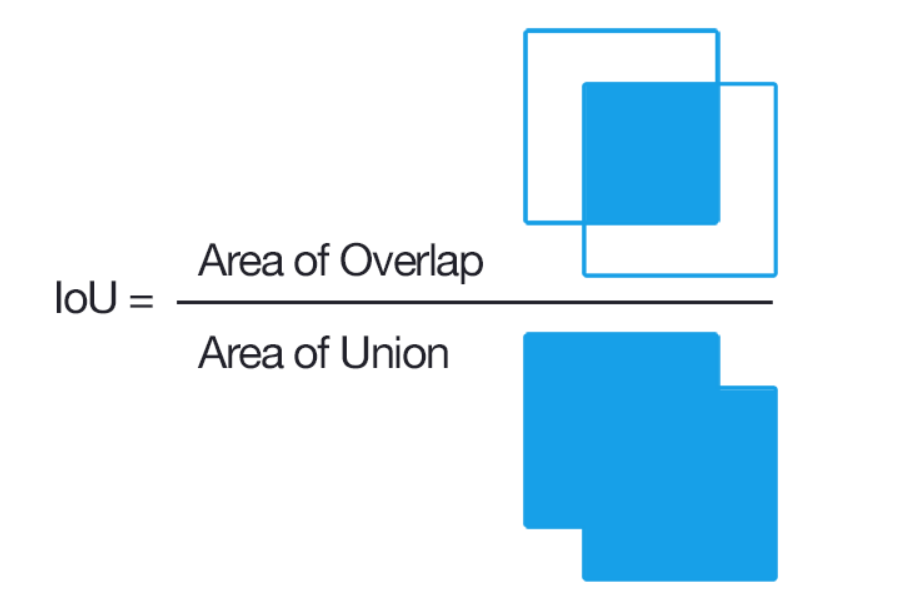

In [2]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.9.2


# Checking the Data split

In [7]:
def Count(path):
  count = 0
  for root,dir,files in os.walk(path):
    count+=len(files)
  return count

In [8]:
# Checking the total number of images 
img_path = '/content/drive/MyDrive/idd20k_lite/leftImg8bit/train'
print ("Total number of training images present: ",Count(img_path))
print('*'*100)
val_path = '/content/drive/MyDrive/idd20k_lite/leftImg8bit/val'
print ("Total number of validation images present: ",Count(val_path))
print('*'*100)
test_path = '/content/drive/MyDrive/idd20k_lite/leftImg8bit/test'
print('Total number of test images present: ',Count(test_path))

Total number of training images present:  1403
****************************************************************************************************
Total number of validation images present:  204
****************************************************************************************************
Total number of test images present:  404


#Visulization of Random Images

<Figure size 720x720 with 0 Axes>

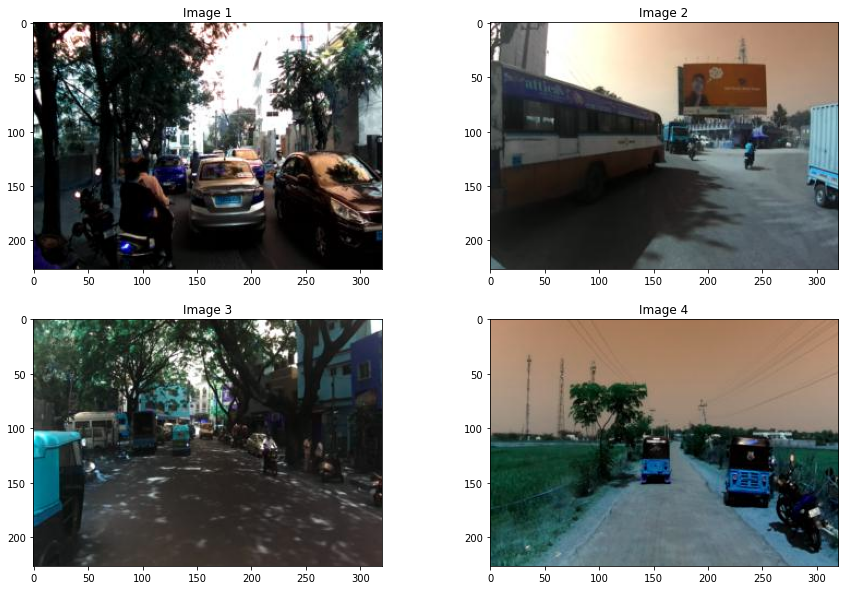

In [78]:
from google.colab.patches import cv2_imshow
#Reading the some random images from the data
img_1 = cv2.imread('/content/drive/MyDrive/idd20k_lite/leftImg8bit/train/117/268450_image.jpg')
img_2 = cv2.imread('/content/drive/MyDrive/idd20k_lite/leftImg8bit/train/139/011161_image.jpg')
img_3 = cv2.imread('/content/drive/MyDrive/idd20k_lite/leftImg8bit/train/168/579123_image.jpg')
img_4 = cv2.imread('/content/drive/MyDrive/idd20k_lite/leftImg8bit/train/209/frame8122_image.jpg')

# Plotting these images
fig = plt.figure(figsize=(15,10))

# Image 1
fig.add_subplot(221) 
plt.title('Image 1')
plt.imshow(img_1)

# Image 2
fig.add_subplot(222)
plt.title('Image 2')
plt.imshow(img_2) 

# Image 3
fig.add_subplot(223)
plt.title('Image 3')
plt.imshow(img_3)

# Image 4
fig.add_subplot(224)
plt.title('Image 4')
plt.imshow(img_4)

Unpredictable road scenes are present in the image. Images have a wide range and dense concentration of automobiles. In the aforementioned photographs, there is a mixture of urban and rural roads, as well as a wide range of traffic.

## Plotting Histogram of the Images

Considering only the first two images from the above photo grid

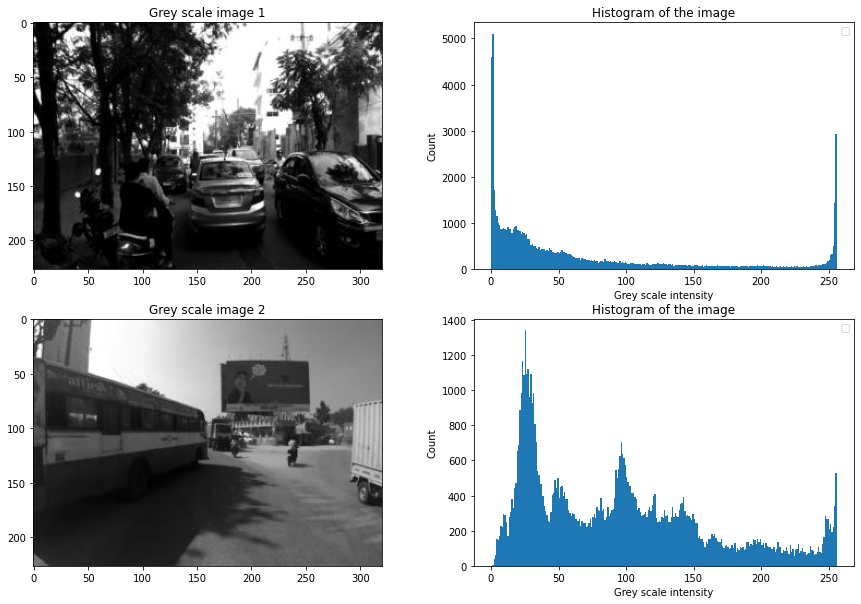

In [85]:
fig = plt.figure(figsize=(15,10))

# Converting the image to gray scale format
fig.add_subplot(221)
plt.title('Grey scale image 1')
gray_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img_1)

# Plotting histogram from gray scale image
fig.add_subplot(222)
plt.legend(['Pixel Intensity'])
plt.xlabel('Grey scale intensity')
plt.ylabel('Count')
plt.title('Histogram of the image')
plt.hist(gray_img_1.ravel(),256,[0,256])

# Converting the image to gray scale format
fig.add_subplot(223)
plt.title('Grey scale image 2')
gray_img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img_2)

# Plotting histogram from gray scale image
fig.add_subplot(224)
plt.legend(['Pixel Intensity'])
plt.xlabel('Grey scale intensity')
plt.ylabel('Count')
plt.title('Histogram of the image')
plt.hist(gray_img_2.ravel(),256,[0,256])

plt.show()

We can determine the distribution of pixel intensity values in the provided image using the histogram plot shown above. The above plot is a representation of an intensity histogram, where Value 0 is Black and Value 255 is White.

Histogram 1: Given that the image's histogram contains more dark-colored pixels, it has a left-skewed distribution.

Histogram 2: The histogram has a non-skewed distribution since there are many different shades for each pixel.

##Plotting RGB Histogram of these two images

Text(0.5, 1.0, 'RGB Histogram of the image')

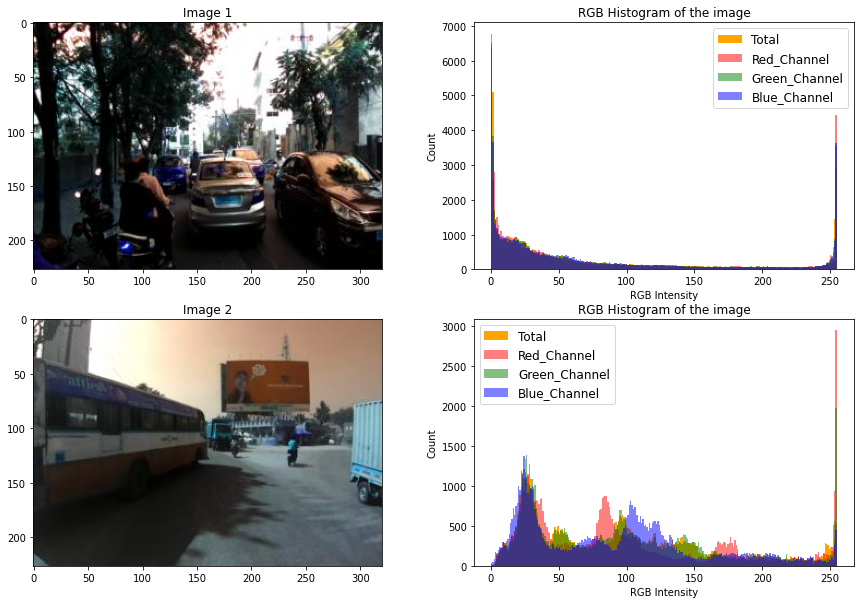

In [100]:
fig = plt.figure(figsize=(15,10))

# Plotting the image
fig.add_subplot(221)
plt.title('Image 1')
plt.imshow(img_1)

# Plotting the RGB Histogram for Image
fig.add_subplot(222)
plt.hist(gray_img_1.ravel(),256,color ='orange')
plt.hist(img_1[:,:,0].ravel(),256,color ='red',alpha=0.5)
plt.hist(img_1[:,:,1].ravel(),256,color ='green',alpha=0.5)
plt.hist(img_1[:,:,2].ravel(),256,color ='blue',alpha=0.5)
plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'],prop={'size': 12})
plt.xlabel('RGB Intensity')
plt.ylabel('Count')
plt.title('RGB Histogram of the image')

# Plotting the image
fig.add_subplot(223)
plt.title('Image 2')
plt.imshow(img_2)

# Plotting the RGB Histogram for Image
fig.add_subplot(224)
plt.hist(gray_img_2.ravel(),256,color ='orange')
plt.hist(img_2[:,:,0].ravel(),256,color ='red',alpha=0.5)
plt.hist(img_2[:,:,1].ravel(),256,color ='green',alpha=0.5)
plt.hist(img_2[:,:,2].ravel(),256,color ='blue',alpha=0.5)
plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'],prop={'size': 12})
plt.xlabel('RGB Intensity')
plt.ylabel('Count')
plt.title('RGB Histogram of the image')

The Red, Blue, and Green intensities for each pixel are shown in the histogram above.

RGB Histogram 1: The image is left-skewed for all 3 intensities since it has higher contrast. Since all the intensities overlap each other in this RGB histogram can not extract any information from this.

RGB Histogram 2: All the pixel intensities are well spread among all the pixels.Similar to the above histogram this histogram is also sligthly left-skewed.

## Reading and viewing the annotated images

<Figure size 720x720 with 0 Axes>

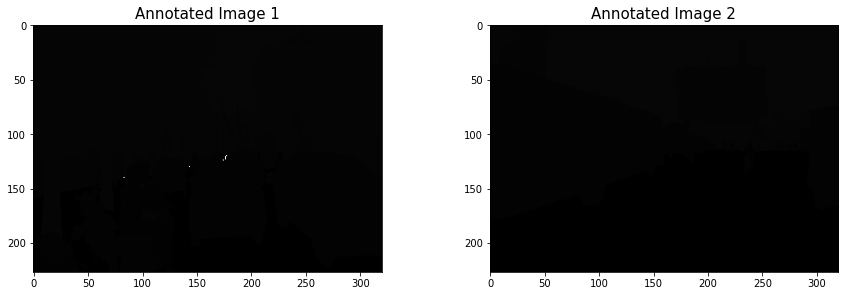

In [114]:
# Here we are plotting the annotated images of the above two images
fig = plt.figure(figsize=(10,10))
an_img_1 = cv2.imread('/content/drive/MyDrive/idd20k_lite/gtFine/train/117/268450_label.png')
an_img_2 = cv2.imread('/content/drive/MyDrive/idd20k_lite/gtFine/train/139/011161_label.png')

fig = plt.figure(figsize=(15,10)) 
fig.add_subplot(221)
plt.title('Annotated Image 1',fontsize=15)
plt.imshow(an_img_1)

fig.add_subplot(222)
plt.title('Annotated Image 2',fontsize=15)
plt.imshow(an_img_2) 

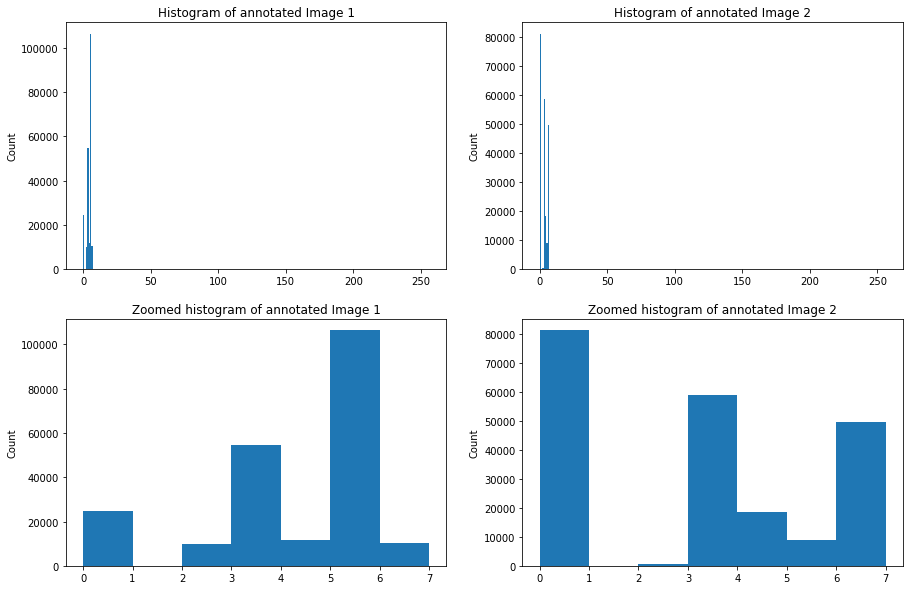

In [113]:
fig = plt.figure(figsize=(15,10))

# Ploting Histogram of annotated Image 1
fig.add_subplot(221)
plt.hist(an_img_1.ravel(),256,[0,256])
plt.title("Histogram of annotated Image 1")
plt.ylabel("Count")

# Ploting Histogram of annotated Image 2
fig.add_subplot(222)
plt.hist(an_img_2.ravel(),256,[0,256])
plt.title("Histogram of annotated Image 2")
plt.ylabel("Count")

# Zooming Histogram of annotated Image 1
fig.add_subplot(223)
plt.hist(an_img_1.ravel(),7,[0,7])
plt.title("Zoomed histogram of annotated Image 1")
plt.ylabel("Count")

# Zooming Histogram of annotated Image 2
fig.add_subplot(224)
plt.hist(an_img_2.ravel(),7,[0,7])
plt.title("Zoomed histogram of annotated Image 2")
plt.ylabel("Count")

plt.show()

Therefore, all of the pixels from the two annotated photos above fall inside the range of 0 to 6 (for 7 classes). With a greater range of pixels, it will be simpler to discern between the pixels since colours fluctuate over a wider range, therefore we may strengthen these pixels to achieve clearer annotations. Each pixel, excluding 0 and 255, will be multiplied by 40, giving us a variety of colours with significant value differences.

## Segmented Images

In [130]:
def Image_segmentation(imagepath):
    img_seg = cv2.imread(imagepath,0)
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j] != 0 or img_seg[i][j] != 255:
                img_seg[i][j] *= 40  
    return img_seg

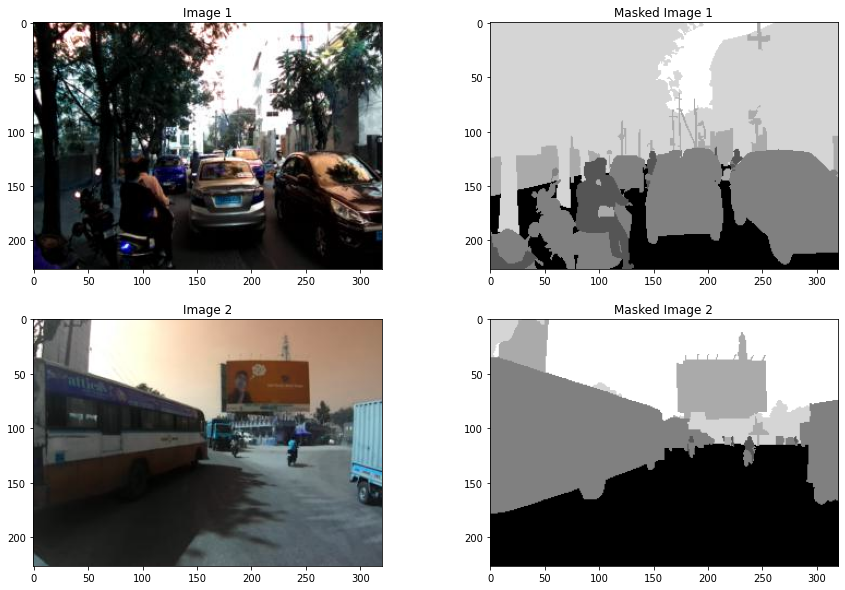

In [129]:
fig = plt.figure(figsize=(15,10))

#Plotting the image
fig.add_subplot(221)
img_1 =  cv2.imread('/content/drive/MyDrive/idd20k_lite/leftImg8bit/train/117/268450_image.jpg')
plt.imshow(img_1)
plt.title("Image 1")

#Original Mask
fig.add_subplot(222)
seg_img_1 = Image_segmentation('/content/drive/MyDrive/idd20k_lite/gtFine/train/117/268450_label.png')
plt.imshow(seg_img_1)
plt.title('Masked Image 1')

#Plotting the image
fig.add_subplot(223)
img_2 =  cv2.imread('/content/drive/MyDrive/idd20k_lite/leftImg8bit/train/139/011161_image.jpg')
plt.imshow(img_2)
plt.title("Image 2")

#Original Mask
fig.add_subplot(224)
seg_img_2 = Image_segmentation('/content/drive/MyDrive/idd20k_lite/gtFine/train/139/011161_label.png')
plt.imshow(seg_img_2)
plt.title('Masked Image 2')

plt.show()

Here we can see the masked image for the corresponding image

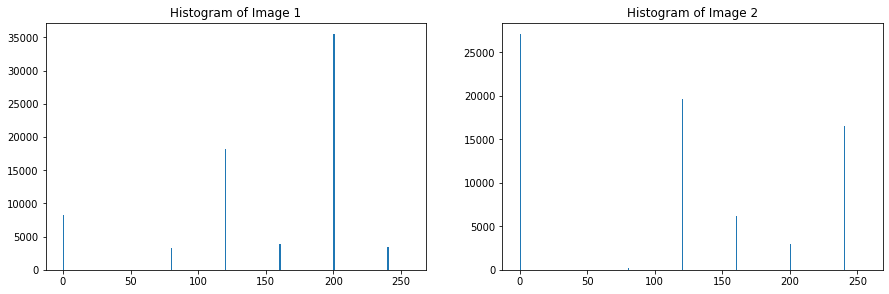

In [132]:
fig = plt.figure(figsize=(15,10))

fig.add_subplot(221)
plt.hist(seg_img_1.ravel(),256,[0,256])
plt.title('Histogram of Image 1')

fig.add_subplot(222)
plt.hist(seg_img_2.ravel(),256,[0,256])
plt.title('Histogram of Image 2')

plt.show()

Since the colours change across a greater range when the pixels were intensified, it was simple to discern the items in the annotated image.